In [128]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfb = tfp.bijectors

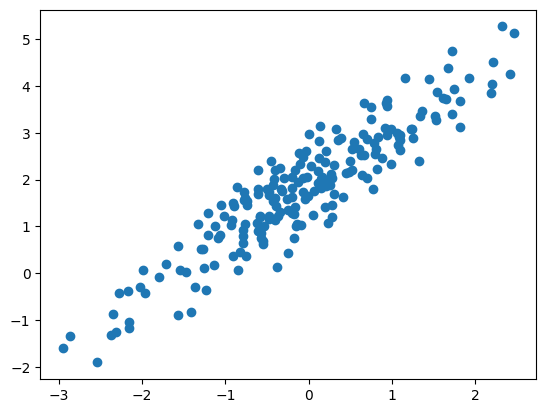

In [129]:
# simulate true model and observed data
N_observations = 200

slope = 1.2
intercept = 1.9
noise_eps = 0.5
x = np.random.normal(0,1, N_observations)#.sample(N_observations)
noise = np.random.normal(0,noise_eps, N_observations)

y = slope*x + intercept + noise

# Convert x and y to TensorFlow tensors
x = tf.convert_to_tensor(x, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

plt.scatter(x,y)

In [247]:
# Target model
model = tfd.JointDistributionSequentialAutoBatched([
    tfd.Normal(loc=1., scale=1., name='m'),   # m
    tfd.Normal(loc=1., scale=1., name='b'),   # b
    tfd.HalfNormal(scale=.7, name='eps'),        # eps
    lambda eps, b, m: tfd.Normal(loc=b*x + m, scale=eps, name='y') # Y
])

# Define target_log_prob_fn like this to remove y from the input
target_log_prob_fn = lambda m, b, eps: model.log_prob([m, b, eps, y])


# surrogate
surrogate =  tfd.JointDistributionSequentialAutoBatched([   
     # m 
    tfd.Normal(
            loc=tf.Variable(1., name='q_m_loc'),
            scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_m_scale'), name='q_m'),
    # b
    tfd.Normal(
            loc=tf.Variable(1., name='q_b_loc'),
            scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_b_scale'), name='q_b'),
    #tfd.HalfNormal(
    #        scale=tfp.util.TransformedVariable(1., bijector=tfb.Softplus(), name='q_b_scale'), name='q_b'),
    # eps
    tfd.LogNormal(
            loc=tf.Variable(0.1, name='q_eps_loc'),
            scale=tfp.util.TransformedVariable(.5, bijector=tfb.Softplus(), name='q_eps_scale'), name='q_eps'),
    #tfd.HalfNormal(
    #        scale=tfp.util.TransformedVariable(0.3, bijector=tfb.Softplus(), name='q_eps_scale'), name='q_eps')
])

print('Trainable variables. Surrogate')
for i, v in enumerate(surrogate.trainable_variables):
    print(i, ':', v)


print('\nmodel graph')
print(model.resolve_graph())

print('\nsurrogate graph')
print(surrogate.resolve_graph())

print('Examples log probs (sample)')
sample = surrogate.sample(5)
for i in sample:
    print(i)
#print(target_log_prob_fn(*sample[::-1]).numpy())
print(target_log_prob_fn(*sample).numpy())
print(surrogate.log_prob(*sample).numpy())

Trainable variables. Surrogate
0 : <tf.Variable 'q_m_loc:0' shape=() dtype=float32, numpy=1.0>
1 : <tf.Variable 'q_m_scale:0' shape=() dtype=float32, numpy=0.54132485>
2 : <tf.Variable 'q_b_loc:0' shape=() dtype=float32, numpy=1.0>
3 : <tf.Variable 'q_b_scale:0' shape=() dtype=float32, numpy=0.54132485>
4 : <tf.Variable 'q_eps_loc:0' shape=() dtype=float32, numpy=0.1>
5 : <tf.Variable 'q_eps_scale:0' shape=() dtype=float32, numpy=-0.43275213>

model graph
(('m', ()), ('b', ()), ('eps', ()), ('y', ('eps', 'b', 'm')))

surrogate graph
(('q_m', ()), ('q_b', ()), ('q_eps', ()))
Examples log probs (sample)
tf.Tensor([ 2.4887729  -2.303236    2.110849    0.65735173  0.51936483], shape=(5,), dtype=float32)
tf.Tensor([ 0.7658569  0.7883428  3.0519214  0.6957158 -0.0632596], shape=(5,), dtype=float32)
tf.Tensor([1.5998703  1.723467   0.78287756 1.2359326  0.64142466], shape=(5,), dtype=float32)
[-315.18076 -901.5921  -878.2368  -356.53128 -980.6092 ]
[-3.9429102 -8.480963  -4.778818  -2.4055026

In [239]:
# Test to verify the logprob. create a marginal plot over each parameters logprob given the other params have the true value.
if False:
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # Intercept (m) plot
    m_linspace = np.linspace(0, 3, 100)
    logprobs_m = [target_log_prob_fn(m_i, slope, noise_eps) for m_i in m_linspace]

    axs[0].plot(m_linspace, logprobs_m)
    axs[0].scatter(intercept, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[0].set_xlabel("Intercept (m)")
    axs[0].set_ylabel("Log Probability")
    axs[0].legend()
    axs[0].set_title("Log Probability vs Intercept (m)")

    # Slope (b) plot
    b_linspace = np.linspace(0, 3, 100)
    logprobs_b = [target_log_prob_fn(intercept, b_i, noise_eps) for b_i in b_linspace]

    axs[1].plot(b_linspace, logprobs_b)
    axs[1].scatter(slope, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[1].set_xlabel("Slope (b)")
    axs[1].set_ylabel("Log Probability")
    axs[1].legend()
    axs[1].set_title("Log Probability vs Slope (b)")

    # Noise (eps) plot
    eps_linspace = np.linspace(0.1, 2, 100)
    logprobs_eps = [target_log_prob_fn(intercept, slope, eps_i) for eps_i in eps_linspace]

    axs[2].plot(eps_linspace, logprobs_eps)
    axs[2].scatter(noise_eps, target_log_prob_fn(intercept, slope, noise_eps), color='red', label='true')
    axs[2].set_xlabel("Noise (eps)")
    axs[2].set_ylabel("Log Probability")
    axs[2].legend()
    axs[2].set_title("Log Probability vs Noise (eps)")

    plt.tight_layout()
    plt.show()

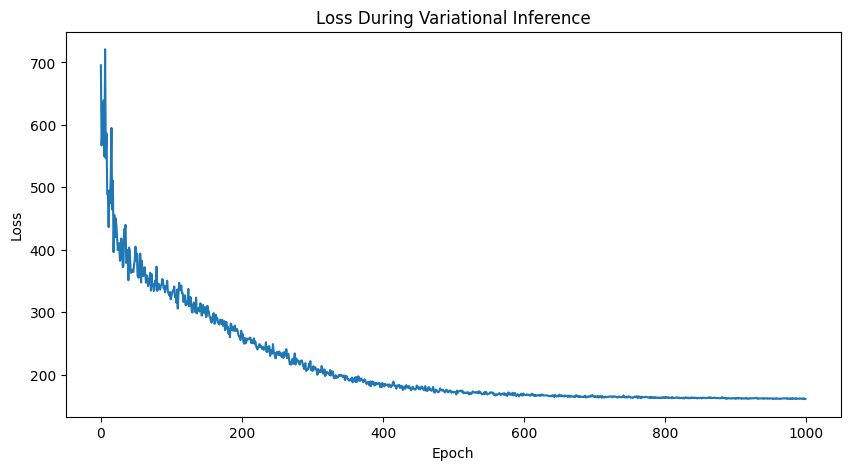

In [248]:
num_steps = 1000
sample_size = 64
learning_rate = 0.01

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=target_log_prob_fn,
    surrogate_posterior=surrogate,
    optimizer=optimizer,
    num_steps=num_steps,
    sample_size=sample_size
)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss During Variational Inference")
plt.show()

In [269]:
[m, b, eps] = np.mean(surrogate.sample(1000), axis=1)
print(m, b , eps)

1.8790833 1.1512011 0.53192335


In [ ]:
print('True params')
print('intercept', intercept)
print('slope', slope)
print('noise_eps', noise_eps)

# Predictions

In [257]:
x_test = np.random.normal(0,1, 50)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)

In [262]:
# Alternative 1 : means of the surrogate posterior distributions to make predictions is a form of point estimation
[m, b, eps] = np.mean(surrogate.sample(1000), axis=1)

prediction_model = tfd.Normal(loc=b*x_test + m, scale=eps)

point_preds = prediction_model.sample()
print(point_preds)


tf.Tensor(
[ 1.3212576   4.081833    1.0807179   0.7091658   0.9020339   5.0981946
  2.459393    4.144277    2.228513   -0.06837684  2.8462434   1.9751264
  2.1019015   1.5803356   2.4285474   2.1154237   2.7639198   2.092399
  2.9278393   3.0993524   3.1374772   1.4709123   3.1296592   2.0771973
  3.9295874   1.2904894   0.790182    4.0058894   0.4915622   0.57334834
  4.4356327   2.575538    1.3318154   2.5253391   0.20468128  0.54207057
  0.9454553   1.7951006   1.1590812   2.1611505   2.313086    1.559847
  3.766498   -0.6404662   3.8047576   2.769256    2.8051357   0.4248947
  2.775665    2.826025  ], shape=(50,), dtype=float32)


In [266]:
# Alt 1.b

pe_preds_deterministic = b*x_test + m
noise = tf.random.normal(shape=x_test.shape, mean=0., stddev=eps)
pe_preds_w_noise = pe_preds_deterministic + noise

print(pe_preds_deterministic)
print(pe_preds_w_noise)

tf.Tensor(
[ 1.1368176   3.831791    2.091177    1.1075778   1.1546625   4.5994024
  1.938732    3.8851466   1.4878333  -0.30186677  2.790099    2.1046383
  1.3976268   1.4724582   1.5936291   2.2383244   2.4481463   2.2740154
  2.8358488   3.63591     3.2700567   1.5491536   2.625807    2.3263705
  3.764063    0.7231951   1.6442134   3.6788867   0.7700329   0.62498164
  3.7052188   2.4773197   1.4421074   1.8525342   0.938431    1.2404907
  0.5129659   1.9004751   1.4597828   2.0131922   2.8473601   1.3298037
  3.0260847   0.52019536  2.3269029   2.9566193   2.5019393   0.9842217
  2.8005629   2.5302663 ], shape=(50,), dtype=float32)
tf.Tensor(
[ 0.7931107   3.9487538   1.8033347   0.9359581   1.6977211   4.8102903
  2.1455824   3.8910148   1.2610688  -0.77360207  2.6147606   1.7221233
  0.8169799   1.4931134   0.66455865  2.2238433   2.2407625   1.5023115
  3.2259762   3.8689613   2.6166935   1.9813764   2.5355542   1.8134247
  3.7884977   0.28656653  0.7570933   4.060196    1.037118

In [268]:
# Alt 2.
n_samples = 1000
samples = surrogate.sample(n_samples)

prediction_model = tfd.Normal(loc=samples[0]*x_test + samples[1], scale=samples[2])

preds = prediction_model.sample()

mean_preds = tf.reduce_mean(predictions, axis=0)
stddev_prediction = tf.math.reduce_std(predictions, axis=0)

InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1000] vs. [50] [Op:Mul]

True params
intercept 1.9
slope 1.2
noise_eps 0.5
